In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_00141_LEFT_MLO_1-1.3.6.1.4.1.9590.100.1.2.132470396811132802311388148633431047614-1.3.6.1.4.1.9590.100.1.2.319647729912087119402966470430252610901-000001._BENIGN-roi.png
/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_01773_RIGHT_CC_1-1.3.6.1.4.1.9590.100.1.2.251873479111874220326365927782688038525-1.3.6.1.4.1.9590.100.1.2.411332629211742096700949712693333832845-000001._BENIGN-roi.png
/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_01882_LEFT_MLO_1-1.3.6.1.4.1.9590.100.1.2.256905759811225865232082510450884767166-1.3.6.1.4.1.9590.100.1.2.58322137412485391810382982722027426694-000001._BENIGN-roi.png
/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_01058_LEFT_MLO_1-1.3.6.1.4.1.9590.100.1.2.280045004412750688539985071920278671695-1.3.6.1.4.1.9590.100.1.2.4181

### Reference for the repository of CBIS-DDSM:
*    Title: MedicalCNN
*    Author: Lai, Leonardo
*    Date: 04/2021
*    Version: 1.0
*    Availability: https://github.com/leoll2/MedicalCNN.git

In [9]:
import sys
import pickle
import itertools
import re

import tensorflow as tf

from tensorflow import keras
from keras import models, optimizers, regularizers
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.utils import plot_model, to_categorical


# path manipulation
from pathlib import Path

# image manipulation
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

In [11]:
cbis_path = '/kaggle/input/cbis-ddsmpatched/CBIS_DDSM'

In [5]:
'''
Personal attempt to divide the dataset differently for classifying one pathology into benign or malignant
one at the time. Time did not allow me to go further into it.
'''
# Load the CSV files
# calc_train_df = pd.read_csv('/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/csv_description/calc_case_description_train_set.csv')
# calc_test_df = pd.read_csv('/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/csv_description/calc_case_description_test_set.csv')

# # Load the numpy data
# train_labels = np.load('/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/numpy data/train_labels.npy')
# train_tensor = np.load('/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/numpy data/train_tensor.npy')
# test_labels = np.load('/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/numpy data/public_test_labels.npy')
# test_tensor = np.load('/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/numpy data/public_test_tensor.npy')


# calc_train_df = calc_train_df[calc_train_df['pathology'].isin(['BENIGN', 'MALIGNANT'])]
# calc_test_df = calc_test_df[calc_test_df['pathology'].isin(['BENIGN', 'MALIGNANT'])]

# calc_train_indices = calc_train_df['patient_id'].values
# calc_test_indices = calc_test_df['patient_id'].values

# calc_train_labels = train_labels[np.isin(train_labels, calc_train_indices)]
# calc_train_tensor = train_tensor[np.isin(train_labels, calc_train_indices)]
# calc_test_labels = test_labels[np.isin(test_labels, calc_test_indices)]
# calc_test_tensor = test_tensor[np.isin(test_labels, calc_test_indices)]

# # Convert the labels to binary (0 for benign, 1 for malignant).
# calc_train_df['binary_label'] = (calc_train_df['pathology'] == 'MALIGNANT').astype(int)
# calc_test_df['binary_label'] = (calc_test_df['pathology'] == 'MALIGNANT').astype(int)

# calc_train_labels_binary = calc_train_df['binary_label'].values
# calc_test_labels_binary = calc_test_df['binary_label'].values


# # Normalize the image data.
# calc_train = calc_train_tensor / 255.0
# calc_test = calc_test_tensor / 255.0

## Classification between Calcifications & Masses


### The data is prepared following these steps:


1.   Import the training and testing data from numpy arrays
2.   Remove the images and labels related to baseline patches (even indices in the arrays)
3.   Adjust the labels for the classification problem, so that 0 corresponds to 'benign mass', 1 to 'malignant mass', 2 to 'bening calcification' and 3 to 'malignant calcification'
4.   Convert the labels to categorical format, required by the categorical_crossentropy loss function
5.   Normalize the pixels to be in the range (0-1) floating point
6.   Shuffle the training set (and labels accordingly, of course)
7.   Split the training data into 'training' and 'validation' subsets ****
8.   Build Keras generators for training and validation data. 

In [12]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [13]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_gen = train_datagen.flow(train_images, train_labels, batch_size=32, subset='training')
val_gen = train_datagen.flow(train_images, train_labels, batch_size=32, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


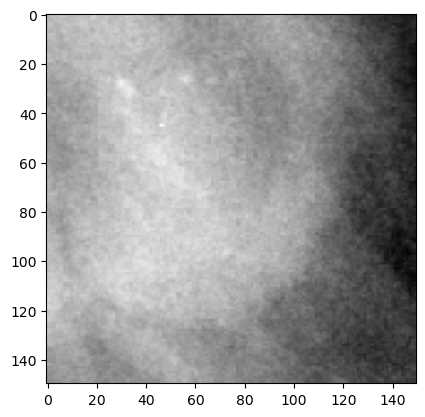

Label: 0


In [14]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

# Experiments

## Trial 0

### First approach to the new dataset, binary-task should perform better compared to the four multi-task

In [17]:
model_0 = Sequential()
model_0.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_0.add(MaxPool2D((2, 2)))
model_0.add(Conv2D(64, (3, 3), activation='relu'))
model_0.add(MaxPool2D((2, 2)))
model_0.add(Flatten())
model_0.add(Dense(16, activation='relu'))
model_0.add(Dropout(0.5))
model_0.add(Dense(1, activation='sigmoid'))

model_0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 16)               

In [19]:
# set optmizer and learning rate
adam = Adam(0.001)

model_0.compile(optimizer=adam,
            loss='binary_crossentropy',
            metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= './CNN/BinaryCBIS', monitor='val_loss',
                                    verbose=1, save_best_only=True,
                                    save_weights_only=False, 
                                    mode='min', save_freq='epoch')
# Train the model
hist_0 = model_0.fit(train_gen, validation_data=val_gen, 
                    epochs=200,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/200
67/67 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.5824
Epoch 1: val_loss improved from inf to 0.61185, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 7s 91ms/step - loss: 0.6513 - accuracy: 0.5824 - val_loss: 0.6118 - val_accuracy: 0.7477
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.5997
Epoch 2: val_loss improved from 0.61185 to 0.57926, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 6s 95ms/step - loss: 0.6336 - accuracy: 0.5997 - val_loss: 0.5793 - val_accuracy: 0.7626
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.6007
Epoch 3: val_loss did not improve from 0.57926
67/67 [==============================] - 5s 72ms/step - loss: 0.6333 - accuracy: 0.6007 - val_loss: 0.5845 - val_accuracy: 0.7607
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6410 - accuracy: 0.5848
Epoch 4: val_loss

In [20]:
models.save_model(model_0, 'model_0_2cl.h5')

In [26]:
# History of accuracy and loss
tra_loss_0 = hist_0.history['loss']
tra_acc_0 = hist_0.history['accuracy']
val_loss_0 = hist_0.history['val_loss']
val_acc_0 = hist_0.history['val_accuracy']

# Total number of epochs training
epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

# Epoch when reached the validation loss minimum
opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

# Loss and accuracy on the validation set
end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

# Loss and accuracy on the test set
opt_model_0 = models.load_model('model_0_2cl.h5')
test_loss_0, test_acc_0 = model_0.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_0, opt_test_acc_0 = opt_model_0.evaluate(test_images, test_labels, verbose=False)
opt_pred_0 = opt_model_0.predict(test_images)
pred_classes_0 = np.rint(opt_pred_0)


print("Model Result\n")
print("Epoch [end]: %d" % end_epoch_0)
print("Epoch [opt]: %d\n" % opt_epoch_0)
print("Valid accuracy [end]: %.4f" % end_val_acc_0)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
print("Test accuracy [end]:  %.4f" % test_acc_0)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_0)
print("Valid loss [end]: %.4f" % end_val_loss_0)
print("Valid loss [opt]: %.4f" % opt_val_loss_0)
print("Test loss [end]:  %.4f" % test_loss_0)
print("Test loss [opt]:  %.4f\n" % opt_test_loss_0)

print(classification_report(test_labels, pred_classes_0, digits=4))

11/11 [==============================] - 0s 5ms/step
Model Result

Epoch [end]: 200
Epoch [opt]: 200

Valid accuracy [end]: 0.8636
Valid accuracy [opt]: 0.8636
Test accuracy [end]:  0.8304
Test accuracy [opt]:  0.8304

Valid loss [end]: 0.3443
Valid loss [opt]: 0.3443
Test loss [end]:  0.4282
Test loss [opt]:  0.4282

              precision    recall  f1-score   support

           0     0.8506    0.8268    0.8385       179
           1     0.8086    0.8344    0.8213       157

    accuracy                         0.8304       336
   macro avg     0.8296    0.8306    0.8299       336
weighted avg     0.8310    0.8304    0.8305       336



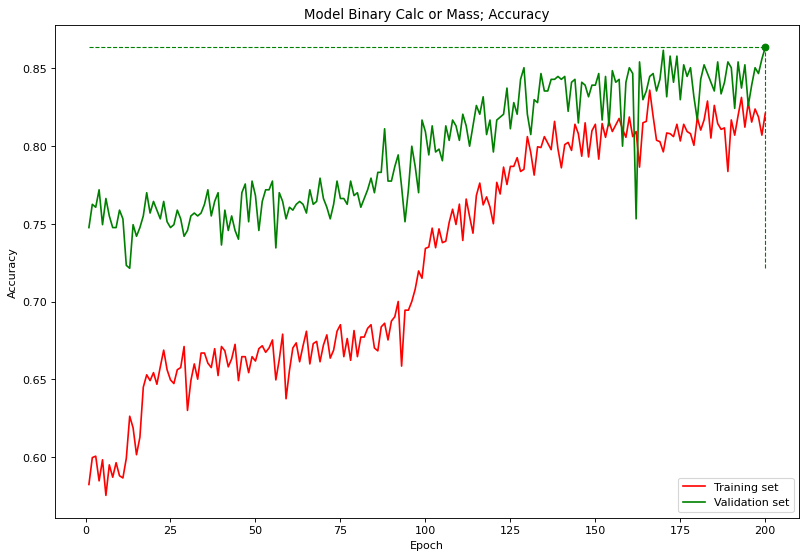

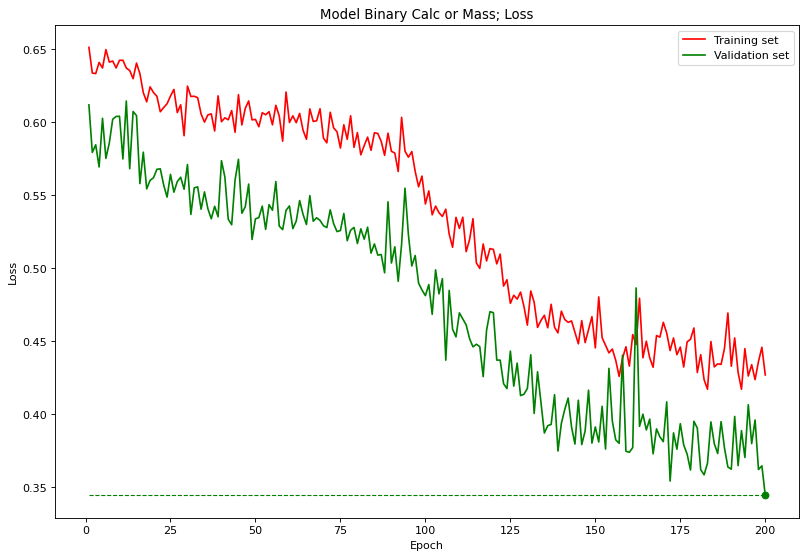

In [120]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Model0Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Model0Loss_figure.png')

## Trial 1


### Previous model demonstrated too simple to fit the data correctly. 
### Increasing complexity in CNN architecture to augment fitting the data, by adding Convs and a Dropout layer after the FC64.

In [30]:
model_1 = Sequential()

model_1.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_1.add(MaxPool2D(pool_size=2, strides=2))
model_1.add(Conv2D(64, kernel_size = (3, 3) ,activation='relu'))
model_1.add(MaxPool2D(pool_size=2, strides=2))
model_1.add(Conv2D(128, kernel_size = (3, 3), activation='relu'))
model_1.add(MaxPool2D(pool_size=2, strides=2))
model_1.add(Conv2D(256, kernel_size = (3, 3), activation='relu'))
model_1.add(MaxPool2D(pool_size=2, strides=2))
model_1.add(Flatten()) 
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid')) 
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 128)     

In [31]:
# set optmizer and learning rate
adam = Adam(0.001)

model_1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= './CNN/BinaryCBIS', monitor='val_loss',
                                    verbose=1, save_best_only=True,
                                    save_weights_only=False, 
                                    mode='min', save_freq='epoch')

# Train the model
hist_1 = model_1.fit(train_gen, validation_data=val_gen, 
                    epochs=200,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/200
67/67 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5339
Epoch 1: val_loss improved from inf to 0.69207, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 65s 966ms/step - loss: 0.6924 - accuracy: 0.5339 - val_loss: 0.6921 - val_accuracy: 0.5626
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5404
Epoch 2: val_loss improved from 0.69207 to 0.68558, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 7s 101ms/step - loss: 0.6920 - accuracy: 0.5404 - val_loss: 0.6856 - val_accuracy: 0.5626
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5404
Epoch 3: val_loss did not improve from 0.68558
67/67 [==============================] - 5s 78ms/step - loss: 0.6924 - accuracy: 0.5404 - val_loss: 0.6865 - val_accuracy: 0.5626
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.5404
Epoch 4: val_l

In [36]:
models.save_model(model_1, 'model_1_2cl.h5')

In [38]:
# History of accuracy and loss
tra_loss_1 = hist_1.history['loss']
tra_acc_1 = hist_1.history['accuracy']
val_loss_1 = hist_1.history['val_loss']
val_acc_1 = hist_1.history['val_accuracy']

# Total number of epochs training
epochs_1 = range(1, len(tra_acc_1)+1)
end_epoch_1 = len(tra_acc_1)

# Epoch when reached the validation loss minimum
opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1-1]
opt_val_acc_1 = val_acc_1[opt_epoch_1-1]

# Loss and accuracy on the test set
opt_model_1 = models.load_model('model_1_2cl.h5')
test_loss_1, test_acc_1 = model_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_1, opt_test_acc_1 = opt_model_1.evaluate(test_images, test_labels, verbose=False)
opt_pred_1 = opt_model_1.predict(test_images)
pred_classes_1 = np.rint(opt_pred_1)

print("Model 1\n")

print("Epoch [end]: %d" % end_epoch_1)
print("Epoch [opt]: %d\n" % opt_epoch_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_1)
print("Test accuracy [end]:  %.4f" % test_acc_1)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_1)
print("Valid loss [end]: %.4f" % end_val_loss_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_1)
print("Test loss [end]:  %.4f" % test_loss_1)
print("Test loss [opt]:  %.4f\n" % opt_test_loss_1)

print(classification_report(test_labels, pred_classes_1, digits=4))

11/11 [==============================] - 0s 7ms/step
Model 1

Epoch [end]: 200
Epoch [opt]: 176

Valid accuracy [end]: 0.8766
Valid accuracy [opt]: 0.8916
Test accuracy [end]:  0.8601
Test accuracy [opt]:  0.8601

Valid loss [end]: 0.2665
Valid loss [opt]: 0.2517
Test loss [end]:  0.3653
Test loss [opt]:  0.3653

              precision    recall  f1-score   support

           0     0.8667    0.8715    0.8691       179
           1     0.8526    0.8471    0.8498       157

    accuracy                         0.8601       336
   macro avg     0.8596    0.8593    0.8595       336
weighted avg     0.8601    0.8601    0.8601       336



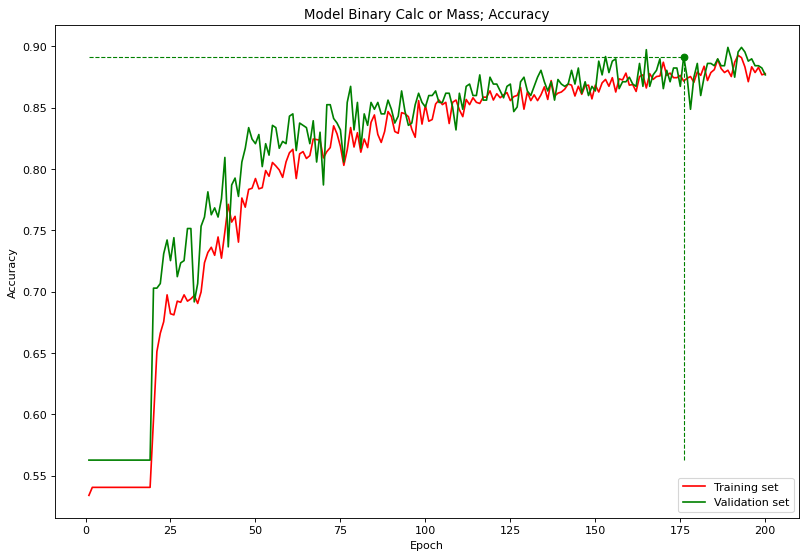

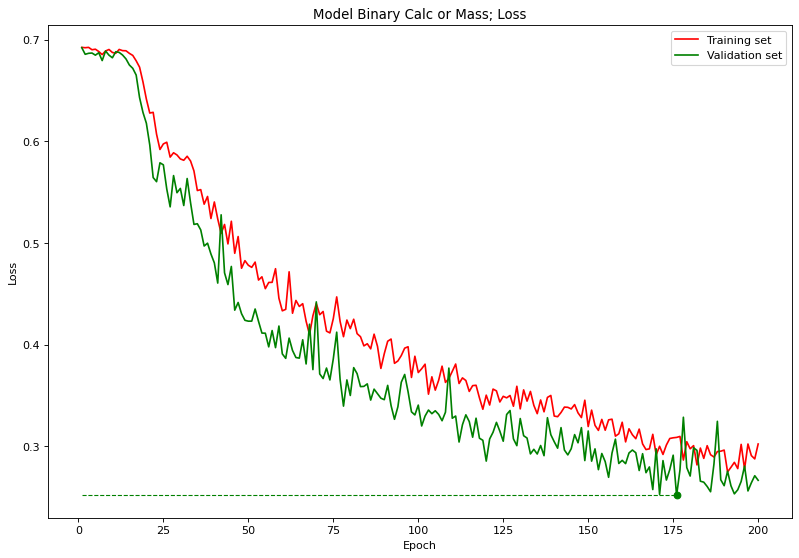

In [119]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_acc_1, 'r', label='Training set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Model1Accuracy_figure')       

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_loss_1, 'r', label='Training set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Model1oss_figure.png')

## Trial 2


### Reducing FC from 64 to 48, to see how it fits the data.

In [49]:
model_2 = Sequential()

model_2.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_2.add(MaxPool2D(pool_size=2, strides=2))
model_2.add(Conv2D(64, kernel_size = (3, 3) ,activation='relu'))
model_2.add(MaxPool2D(pool_size=2, strides=2))
model_2.add(Conv2D(128, kernel_size = (3, 3), activation='relu'))
model_2.add(MaxPool2D(pool_size=2, strides=2))
model_2.add(Conv2D(256, kernel_size = (3, 3), activation='relu'))
model_2.add(MaxPool2D(pool_size=2, strides=2))
model_2.add(Flatten()) 
model_2.add(Dense(48, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation='sigmoid')) 
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 17, 17, 128)     

In [50]:
# set optmizer and learning rate
adam = Adam(0.001)

model_2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= './CNN/BinaryCBIS', monitor='val_loss',
                                    verbose=1, save_best_only=True,
                                    save_weights_only=False, 
                                    mode='min', save_freq='epoch')

# Train the model
hist_2 = model_2.fit(train_gen, validation_data=val_gen, 
                    epochs=200,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/200
67/67 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.5245
Epoch 1: val_loss improved from inf to 0.69017, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 7s 97ms/step - loss: 0.6950 - accuracy: 0.5245 - val_loss: 0.6902 - val_accuracy: 0.5626
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5404
Epoch 2: val_loss improved from 0.69017 to 0.68521, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 6s 90ms/step - loss: 0.6913 - accuracy: 0.5404 - val_loss: 0.6852 - val_accuracy: 0.5626
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.5409
Epoch 3: val_loss improved from 0.68521 to 0.68443, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 7s 105ms/step - loss: 0.6898 - accuracy: 0.5409 - val_loss: 0.6844 - val_accuracy: 0.5626
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.68

In [51]:
models.save_model(model_2, 'model_2_2cl.h5')

In [52]:
# History of accuracy and loss
tra_loss_2 = hist_2.history['loss']
tra_acc_2 = hist_2.history['accuracy']
val_loss_2 = hist_2.history['val_loss']
val_acc_2 = hist_2.history['val_accuracy']

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2)+1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2-1]
opt_val_acc_2 = val_acc_2[opt_epoch_2-1]

# Loss and accuracy on the test set
opt_model_2 = models.load_model('model_2_2cl.h5')
test_loss_2, test_acc_2 = model_2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_2, opt_test_acc_2 = opt_model_2.evaluate(test_images, test_labels, verbose=False)
opt_pred_2 = opt_model_2.predict(test_images)
pred_classes_2 = np.rint(opt_pred_2)

print("Model 2\n")

print("Epoch [end]: %d" % end_epoch_2)
print("Epoch [opt]: %d\n" % opt_epoch_2)
print("Valid accuracy [end]: %.4f" % end_val_acc_2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_2)
print("Test accuracy [end]:  %.4f" % test_acc_2)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_2)
print("Valid loss [end]: %.4f" % end_val_loss_2)
print("Valid loss [opt]: %.4f" % opt_val_loss_2)
print("Test loss [end]:  %.4f" % test_loss_2)
print("Test loss [opt]:  %.4f\n" % opt_test_loss_2)

print(classification_report(test_labels, pred_classes_2, digits=4))

11/11 [==============================] - 0s 7ms/step
Model 2

Epoch [end]: 200
Epoch [opt]: 180

Valid accuracy [end]: 0.8841
Valid accuracy [opt]: 0.8822
Test accuracy [end]:  0.8571
Test accuracy [opt]:  0.8571

Valid loss [end]: 0.2691
Valid loss [opt]: 0.2671
Test loss [end]:  0.3573
Test loss [opt]:  0.3573

              precision    recall  f1-score   support

           0     0.8579    0.8771    0.8674       179
           1     0.8562    0.8344    0.8452       157

    accuracy                         0.8571       336
   macro avg     0.8571    0.8557    0.8563       336
weighted avg     0.8571    0.8571    0.8570       336



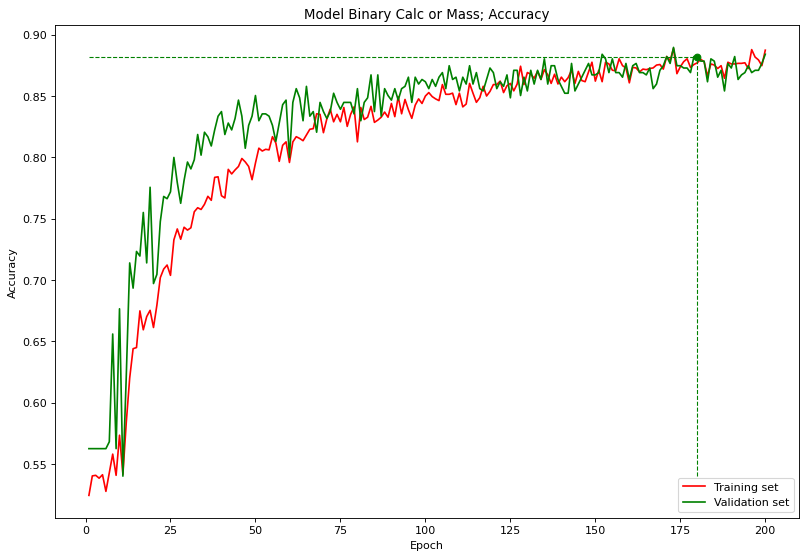

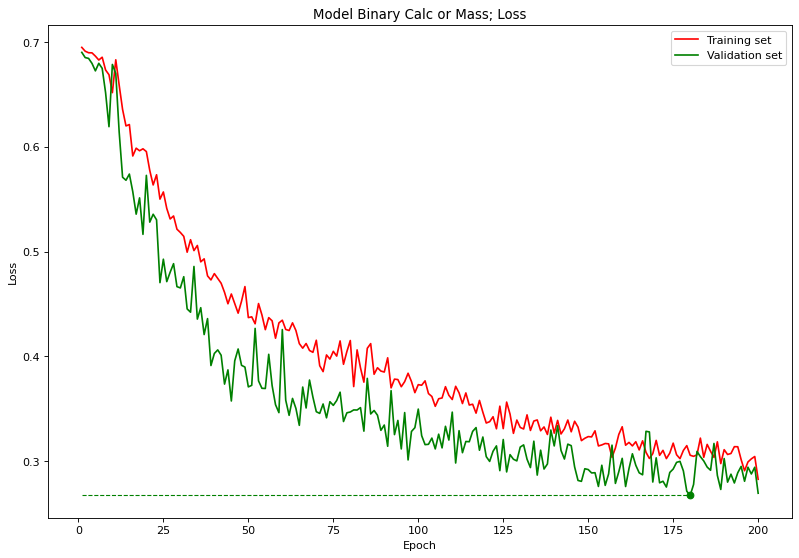

In [118]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Model2Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Model2Loss_figure.png')

## Trial 3


### The difference in results wasn't significant, the Model 1 perfomed slighlty better over val_acc, test_acc and F1-score, however the Model 2, performed slightly better on the test_loss. Moreover, both have small symptoms of over regularazing the data, as the val loss is less and the loss. Therefore, the Model 1 will be carried on for the next experiment, increasing the epochs, lowering the learing rate, and halfing the Dropout value, to see how well it performs on a longer fitting run.

In [78]:
model_3 = Sequential()

model_3.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_3.add(MaxPool2D(pool_size=2, strides=2))
model_3.add(Conv2D(64, kernel_size = (3, 3) ,activation='relu'))
model_3.add(MaxPool2D(pool_size=2, strides=2))
model_3.add(Conv2D(128, kernel_size = (3, 3), activation='relu'))
model_3.add(MaxPool2D(pool_size=2, strides=2))
model_3.add(Conv2D(256, kernel_size = (3, 3), activation='relu'))
model_3.add(MaxPool2D(pool_size=2, strides=2))
model_3.add(Flatten())
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(1, activation='sigmoid')) 
model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 17, 17, 128)    

In [79]:
# set optmizer and learning rate
adam = Adam(0.0001)

model_3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= './CNN/BinaryCBIS', monitor='val_loss',
                                    verbose=1, save_best_only=True,
                                    save_weights_only=False, 
                                    mode='min', save_freq='epoch')

# Train the model
hist_3 = model_3.fit(train_gen, validation_data=val_gen, 
                    epochs=350,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/350
67/67 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5376
Epoch 1: val_loss improved from inf to 0.68990, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 7s 96ms/step - loss: 0.6920 - accuracy: 0.5376 - val_loss: 0.6899 - val_accuracy: 0.5626
Epoch 2/350
67/67 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.5469
Epoch 2: val_loss improved from 0.68990 to 0.68182, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 7s 101ms/step - loss: 0.6899 - accuracy: 0.5469 - val_loss: 0.6818 - val_accuracy: 0.5626
Epoch 3/350
67/67 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.5871
Epoch 3: val_loss improved from 0.68182 to 0.67564, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 6s 93ms/step - loss: 0.6859 - accuracy: 0.5871 - val_loss: 0.6756 - val_accuracy: 0.5850
Epoch 4/350
67/67 [==============================] - ETA: 0s - loss: 0.67

In [80]:
models.save_model(model_3, 'model_3_2cl.h5')

In [81]:
# History of accuracy and loss
tra_loss_3 = hist_3.history['loss']
tra_acc_3 = hist_3.history['accuracy']
val_loss_3 = hist_3.history['val_loss']
val_acc_3 = hist_3.history['val_accuracy']

# Total number of epochs training
epochs_3 = range(1, len(tra_acc_3)+1)
end_epoch_3 = len(tra_acc_3)

# Epoch when reached the validation loss minimum
opt_epoch_3 = val_loss_3.index(min(val_loss_3)) + 1

# Loss and accuracy on the validation set
end_val_loss_3 = val_loss_3[-1]
end_val_acc_3 = val_acc_3[-1]
opt_val_loss_3 = val_loss_3[opt_epoch_3-1]
opt_val_acc_3 = val_acc_3[opt_epoch_3-1]

# Loss and accuracy on the test set
opt_model_3 = models.load_model('model_3_2cl.h5')
test_loss_3, test_acc_3 = model_3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_3, opt_test_acc_3 = opt_model_3.evaluate(test_images, test_labels, verbose=False)
opt_pred_3 = opt_model_3.predict(test_images)
pred_classes_3 = np.rint(opt_pred_3)

print("Model 3\n")

print("Epoch [end]: %d" % end_epoch_3)
print("Epoch [opt]: %d" % opt_epoch_3)
print("Valid accuracy [end]: %.4f" % end_val_acc_3)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_3)
print("Test accuracy [end]:  %.4f" % test_acc_3)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_3)
print("Valid loss [end]: %.4f" % end_val_loss_3)
print("Valid loss [opt]: %.4f" % opt_val_loss_3)
print("Test loss [end]:  %.4f" % test_loss_3)
print("Test loss [opt]:  %.4f" % opt_test_loss_3)

print(classification_report(test_labels, pred_classes_3, digits=4))

11/11 [==============================] - 0s 7ms/step
Model 3

Epoch [end]: 350
Epoch [opt]: 338
Valid accuracy [end]: 0.9290
Valid accuracy [opt]: 0.9178
Test accuracy [end]:  0.8869
Test accuracy [opt]:  0.8869
Valid loss [end]: 0.2027
Valid loss [opt]: 0.2026
Test loss [end]:  0.3084
Test loss [opt]:  0.3084
              precision    recall  f1-score   support

           0     0.9172    0.8659    0.8908       179
           1     0.8563    0.9108    0.8827       157

    accuracy                         0.8869       336
   macro avg     0.8867    0.8884    0.8868       336
weighted avg     0.8887    0.8869    0.8870       336



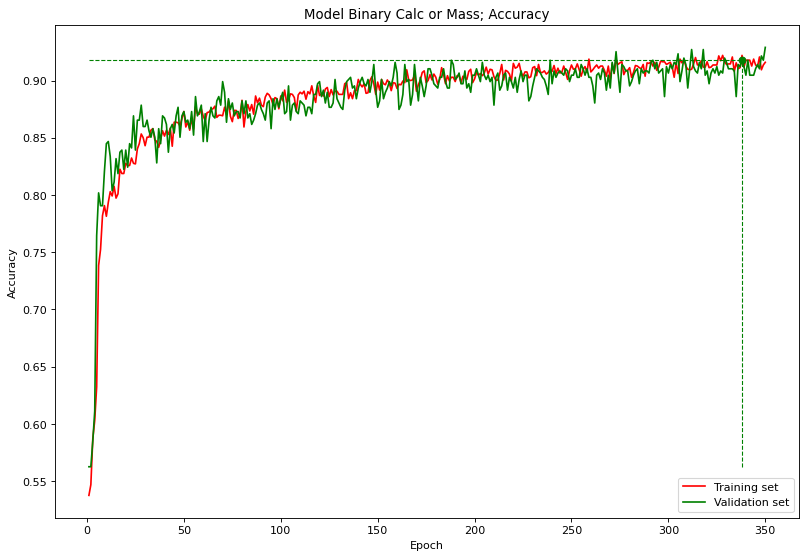

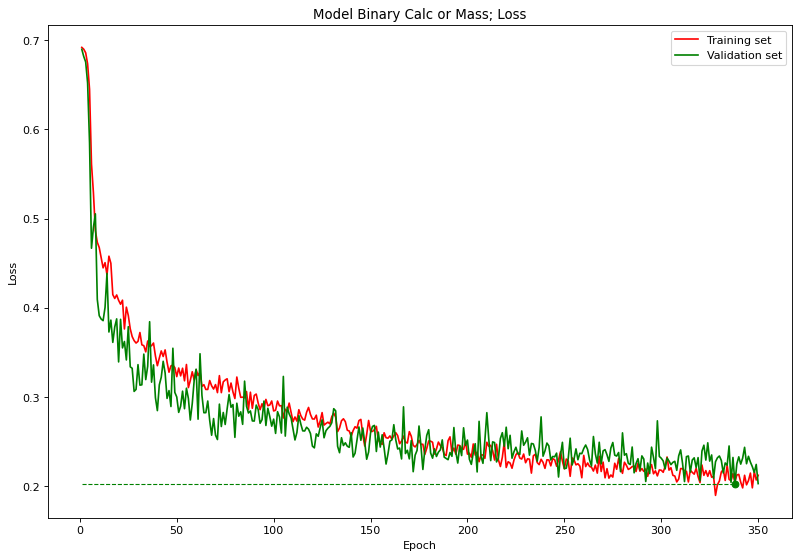

In [117]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_acc_3, 'r', label='Training set')
plt.plot(epochs_3, val_acc_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_acc_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_acc_3), opt_val_acc_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Model3Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_loss_3, 'r', label='Training set')
plt.plot(epochs_3, val_loss_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_loss_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_loss_3), opt_val_loss_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Model3Loss_figure.png')

## Trial 4

### The last model has outperformed the previous two, although just by little, it is important to consider this a good choice of hyperparameters and, therefore direction. The regularization did slightly improve, balancing after 200 epochs circa. However, this took longer and yielded a better result over an extra 150 epochs.

In [84]:
model_4 = Sequential()

model_4.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(150, 150, 1), kernel_regularizer = regularizers.l2(0.00005)))
model_4.add(MaxPool2D(pool_size=2, strides=2))
model_4.add(Conv2D(64, kernel_size = (3, 3) ,activation='relu', kernel_regularizer = regularizers.l2(0.00005)))
model_4.add(MaxPool2D(pool_size=2, strides=2))
model_4.add(Conv2D(128, kernel_size = (3, 3), activation='relu', kernel_regularizer = regularizers.l2(0.00005)))
model_4.add(MaxPool2D(pool_size=2, strides=2))
model_4.add(Conv2D(256, kernel_size = (3, 3), activation='relu', kernel_regularizer = regularizers.l2(0.00005)))
model_4.add(MaxPool2D(pool_size=2, strides=2))
model_4.add(Flatten()) 
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(1, activation='sigmoid')) 
model_4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 17, 17, 128)    

In [85]:
# set optmizer and learning rate
adam = Adam(0.0001)

model_4.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= './CNN/BinaryCBIS', monitor='val_loss',
                                    verbose=1, save_best_only=True,
                                    save_weights_only=False, 
                                    mode='min', save_freq='epoch')

# Train the model
hist_4 = model_4.fit(train_gen, validation_data=val_gen, 
                    epochs = 350,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/350
67/67 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.5399
Epoch 1: val_loss improved from inf to 0.70612, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 7s 98ms/step - loss: 0.7053 - accuracy: 0.5399 - val_loss: 0.7061 - val_accuracy: 0.5626
Epoch 2/350
67/67 [==============================] - ETA: 0s - loss: 0.6998 - accuracy: 0.5404
Epoch 2: val_loss improved from 0.70612 to 0.69598, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 7s 106ms/step - loss: 0.6998 - accuracy: 0.5404 - val_loss: 0.6960 - val_accuracy: 0.5626
Epoch 3/350
67/67 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.5582
Epoch 3: val_loss improved from 0.69598 to 0.65776, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 7s 97ms/step - loss: 0.6833 - accuracy: 0.5582 - val_loss: 0.6578 - val_accuracy: 0.6374
Epoch 4/350
67/67 [==============================] - ETA: 0s - loss: 0.65

In [86]:
models.save_model(model_4, 'model_4_2cl.h5')

In [88]:
# History of accuracy and loss
tra_loss_4 = hist_4.history['loss']
tra_acc_4 = hist_4.history['accuracy']
val_loss_4 = hist_4.history['val_loss']
val_acc_4 = hist_4.history['val_accuracy']

# Total number of epochs training
epochs_4 = range(1, len(tra_acc_4)+1)
end_epoch_4 = len(tra_acc_4)

# Epoch when reached the validation loss minimum
opt_epoch_4 = val_loss_4.index(min(val_loss_4)) + 1

# Loss and accuracy on the validation set
end_val_loss_4 = val_loss_4[-1]
end_val_acc_4 = val_acc_4[-1]
opt_val_loss_4 = val_loss_4[opt_epoch_4-1]
opt_val_acc_4 = val_acc_4[opt_epoch_4-1]

# Loss and accuracy on the test set
opt_model_4 = models.load_model('model_4_2cl.h5')
test_loss_4, test_acc_4 = model_4.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_4, opt_test_acc_4 = opt_model_4.evaluate(test_images, test_labels, verbose=False)
opt_pred_4 = opt_model_4.predict(test_images)
pred_classes_4 = np.rint(opt_pred_4)

print("Model 4\n")

print("Epoch [end]: %d" % end_epoch_4)
print("Epoch [opt]: %d" % opt_epoch_4)
print("Valid accuracy [end]: %.4f" % end_val_acc_4)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_4)
print("Test accuracy [end]:  %.4f" % test_acc_4)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_4)
print("Valid loss [end]: %.4f" % end_val_loss_4)
print("Valid loss [opt]: %.4f" % opt_val_loss_4)
print("Test loss [end]:  %.4f" % test_loss_4)
print("Test loss [opt]:  %.4f" % opt_test_loss_4)

print(classification_report(test_labels, pred_classes_4, digits=4))

11/11 [==============================] - 0s 7ms/step
Model 4

Epoch [end]: 146
Epoch [opt]: 96
Valid accuracy [end]: 0.8897
Valid accuracy [opt]: 0.8897
Test accuracy [end]:  0.8571
Test accuracy [opt]:  0.8571
Valid loss [end]: 0.2687
Valid loss [opt]: 0.2614
Test loss [end]:  0.3978
Test loss [opt]:  0.3978
              precision    recall  f1-score   support

           0     0.9580    0.7654    0.8509       179
           1     0.7824    0.9618    0.8629       157

    accuracy                         0.8571       336
   macro avg     0.8702    0.8636    0.8569       336
weighted avg     0.8760    0.8571    0.8565       336



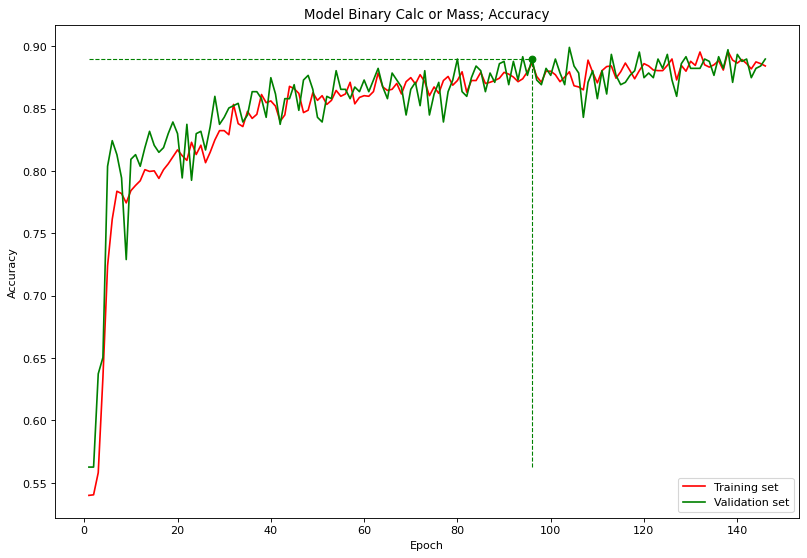

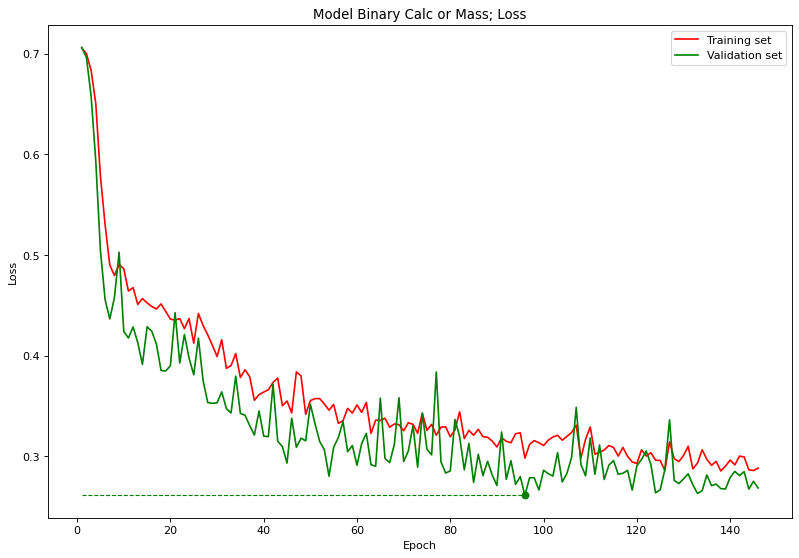

In [116]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_4, tra_acc_4, 'r', label='Training set')
plt.plot(epochs_4, val_acc_4, 'g', label='Validation set')
plt.plot(opt_epoch_4, val_acc_4[opt_epoch_4-1], 'go')
plt.vlines(opt_epoch_4, min(val_acc_4), opt_val_acc_4, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_4, 1, opt_epoch_4, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Model4Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_4, tra_loss_4, 'r', label='Training set')
plt.plot(epochs_4, val_loss_4, 'g', label='Validation set')
plt.plot(opt_epoch_4, val_loss_4[opt_epoch_4-1], 'go')
plt.vlines(opt_epoch_4, min(val_loss_4), opt_val_loss_4, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_4, 1, opt_epoch_4, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Model4Loss_figure.png')

## Trial 5

### Althought the previous model has achieved good level relatively quiclky, it did not exceed the overall metrics of Model 3, apart from precision over Masses. Therefore, another approach must be taken.

In [90]:
model_5 = Sequential()

model_5.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_5.add(MaxPool2D(pool_size=2, strides=2))
model_5.add(Conv2D(64, kernel_size = (3, 3) ,activation='relu'))
model_5.add(MaxPool2D(pool_size=2, strides=2))
model_5.add(Conv2D(128, kernel_size = (3, 3), activation='relu'))
model_5.add(MaxPool2D(pool_size=2, strides=2))
model_5.add(Conv2D(256, kernel_size = (3, 3), activation='relu'))
model_5.add(MaxPool2D(pool_size=2, strides=2))
model_5.add(Flatten()) 
model_5.add(Dense(128, activation='relu', activity_regularizer = regularizers.l2(1e-4)))
model_5.add(Dropout(0.25))
model_5.add(Dense(1, activation='sigmoid')) 
model_5.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 17, 17, 128)    

In [91]:
# set optmizer and learning rate
adam = Adam(0.0001)

model_5.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= './CNN/BinaryCBIS', monitor='val_loss',
                                    verbose=1, save_best_only=True,
                                    save_weights_only=False, 
                                    mode='min', save_freq='epoch')

# Train the model
hist_5 = model_5.fit(train_gen, validation_data=val_gen, 
                    epochs=500,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/500
67/67 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5292
Epoch 1: val_loss improved from inf to 0.68868, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 8s 109ms/step - loss: 0.6926 - accuracy: 0.5292 - val_loss: 0.6887 - val_accuracy: 0.5626
Epoch 2/500
67/67 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5413
Epoch 2: val_loss improved from 0.68868 to 0.68734, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 6s 97ms/step - loss: 0.6918 - accuracy: 0.5413 - val_loss: 0.6873 - val_accuracy: 0.5626
Epoch 3/500
67/67 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.5446
Epoch 3: val_loss improved from 0.68734 to 0.65949, saving model to ./CNN/BinaryCBIS
67/67 [==============================] - 7s 105ms/step - loss: 0.6844 - accuracy: 0.5446 - val_loss: 0.6595 - val_accuracy: 0.5907
Epoch 4/500
67/67 [==============================] - ETA: 0s - loss: 0.6

In [97]:
models.save_model(model_5, 'model_5_2cl.h5')

In [93]:
# History of accuracy and loss
tra_loss_5 = hist_5.history['loss']
tra_acc_5 = hist_5.history['accuracy']
val_loss_5 = hist_5.history['val_loss']
val_acc_5 = hist_5.history['val_accuracy']

# Total number of epochs training
epochs_5 = range(1, len(tra_acc_5)+1)
end_epoch_5 = len(tra_acc_5)

# Epoch when reached the validation loss minimum
opt_epoch_5 = val_loss_5.index(min(val_loss_5)) + 1

# Loss and accuracy on the validation set
end_val_loss_5 = val_loss_5[-1]
end_val_acc_5 = val_acc_5[-1]
opt_val_loss_5 = val_loss_5[opt_epoch_5-1]
opt_val_acc_5 = val_acc_5[opt_epoch_5-1]

# Loss and accuracy on the test set
opt_model_5 = models.load_model('model_5_2cl.h5')
test_loss_5, test_acc_5 = model_5.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_5, opt_test_acc_5 = opt_model_5.evaluate(test_images, test_labels, verbose=False)
opt_pred_5 = opt_model_5.predict(test_images)
pred_classes_5 = np.rint(opt_pred_5)

print("Model 5\n")

print("Epoch [end]: %d" % end_epoch_5)
print("Epoch [opt]: %d" % opt_epoch_5)
print("Valid accuracy [end]: %.4f" % end_val_acc_5)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_5)
print("Test accuracy [end]:  %.4f" % test_acc_5)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_5)
print("Valid loss [end]: %.4f" % end_val_loss_5)
print("Valid loss [opt]: %.4f" % opt_val_loss_5)
print("Test loss [end]:  %.4f" % test_loss_5)
print("Test loss [opt]:  %.4f" % opt_test_loss_5)

print(classification_report(test_labels, pred_classes_5, digits=4))

11/11 [==============================] - 0s 7ms/step
Model 5

Epoch [end]: 500
Epoch [opt]: 478
Valid accuracy [end]: 0.9140
Valid accuracy [opt]: 0.9346
Test accuracy [end]:  0.8988
Test accuracy [opt]:  0.8988
Valid loss [end]: 0.2280
Valid loss [opt]: 0.1886
Test loss [end]:  0.3464
Test loss [opt]:  0.3464
              precision    recall  f1-score   support

           0     0.9290    0.8771    0.9023       179
           1     0.8683    0.9236    0.8951       157

    accuracy                         0.8988       336
   macro avg     0.8986    0.9003    0.8987       336
weighted avg     0.9006    0.8988    0.8989       336



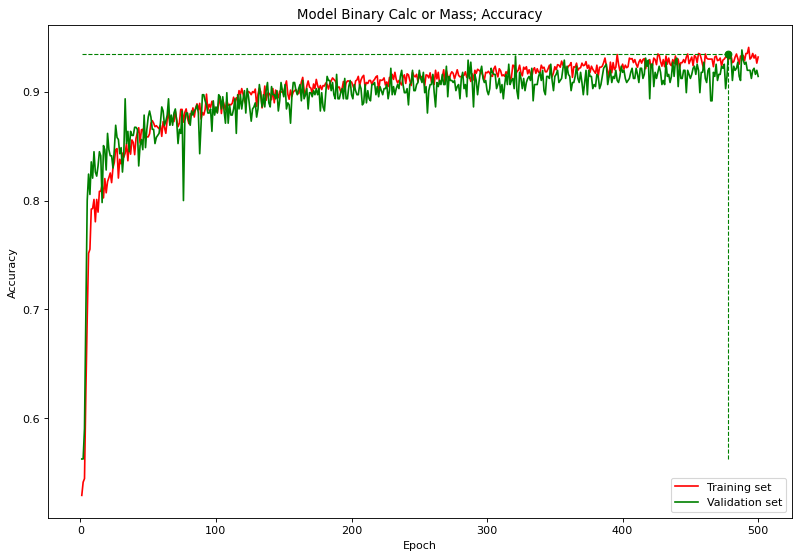

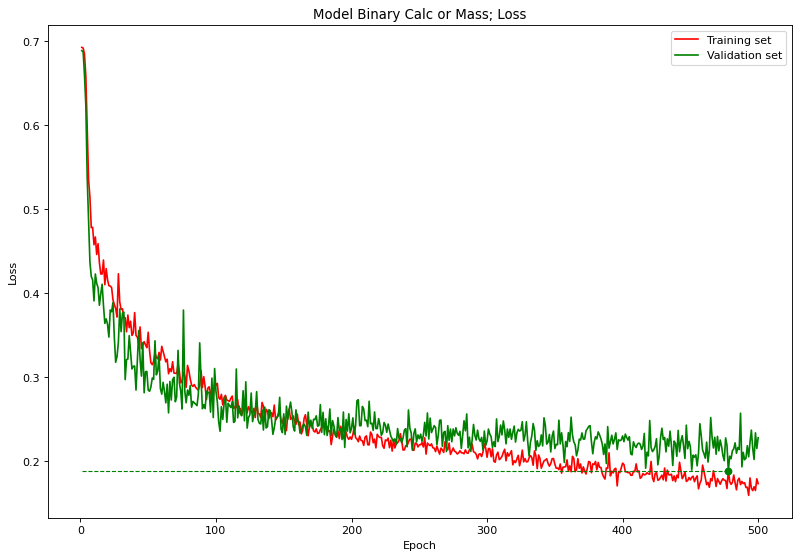

In [115]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_5, tra_acc_5, 'r', label='Training set')
plt.plot(epochs_5, val_acc_5, 'g', label='Validation set')
plt.plot(opt_epoch_5, val_acc_5[opt_epoch_5-1], 'go')
plt.vlines(opt_epoch_5, min(val_acc_5), opt_val_acc_5, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_5, 1, opt_epoch_5, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Model5Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calc or Mass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_5, tra_loss_5, 'r', label='Training set')
plt.plot(epochs_5, val_loss_5, 'g', label='Validation set')
plt.plot(opt_epoch_5, val_loss_5[opt_epoch_5-1], 'go')
plt.vlines(opt_epoch_5, min(val_loss_5), opt_val_loss_5, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_5, 1, opt_epoch_5, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Model5Loss_figure.png')

## Visualising Tests and Results

In [98]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [99]:
def plot_roc(preds, names, titles='ROC curve'):
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    for pred, name in zip(preds, names):
        fpr, tpr, _ = roc_curve(test_labels, pred)
        auc_keras = auc(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=(name +' (area = {:.3f})'.format(auc_keras)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()
    plt.savefig('ROC_Curve_CBIS-DDSM.png')

In [124]:
def get_errors(pred):
    errors = []
    mispred = []
    hard_mispred = []

    for l,p,img in zip(test_labels, pred, test_images):
        err = abs(l-p)
        errors.append(err)
        if err > 0.5:
            mispred.append((l,p,img))
        if err > 0.8:
            hard_mispred.append((l,p,img))

    return errors, mispred, hard_mispred


def show_error_stats(errors, mispred, hard_mispred):

    print("Number of test images: %d" % len(test_labels))
    print("Mispredictions: %d" % len(mispred))
    print("Hard mispred: %d" % len(hard_mispred))

    sns.distplot(errors, kde=False, rug=True, bins=10, vertical=False, label='samples', axlabel='error').set_title('Absolute error distribution');

    for l,p,img in hard_mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('mass' if l==0 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))
        plt.axis('off')


opt_model_2 = models.load_model('model_2_2cl.h5')
opt_model_3 = models.load_model('model_3_2cl.h5')
opt_model_5 = models.load_model('model_5_2cl.h5')


pred_0 = opt_model_0.predict(test_images)
pred_1 = opt_model_1.predict(test_images)
pred_2 = opt_model_2.predict(test_images)
pred_3 = opt_model_3.predict(test_images)
pred_4 = opt_model_4.predict(test_images)
pred_5 = opt_model_5.predict(test_images)

errors_2, mispred_2, hard_mispred_2 = get_errors(pred_2)
errors_3, mispred_3, hard_mispred_3 = get_errors(pred_3)
errors_5, mispred_5, hard_mispred_5 = get_errors(pred_5)

11/11 [==============================] - 0s 7ms/step


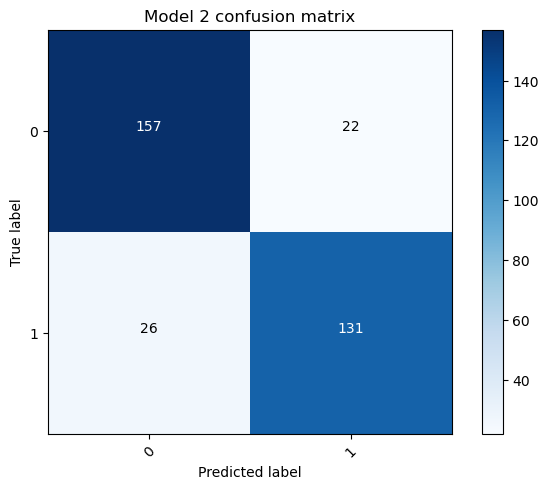

In [112]:
pred_2_classes = np.rint(pred_2)
confusion_mtx = confusion_matrix(test_labels, pred_2_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 2 confusion matrix')
plt.savefig('ConfusionMatrixModel2(CBIS-DDSM).png')

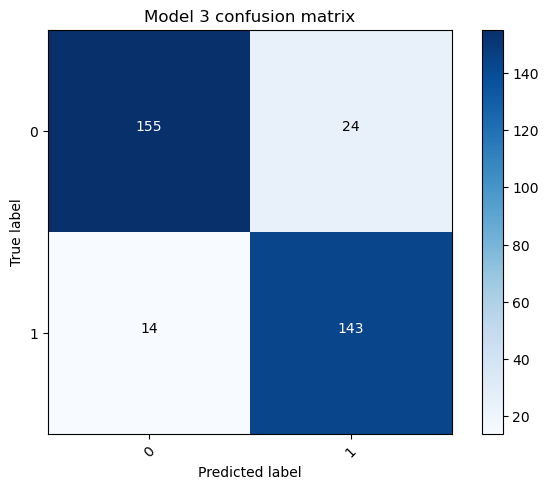

In [113]:
pred_3_classes = np.rint(pred_3)
confusion_mtx = confusion_matrix(test_labels, pred_3_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 3 confusion matrix')
plt.savefig('ConfusionMatrixModel3(CBIS-DDSM).png')

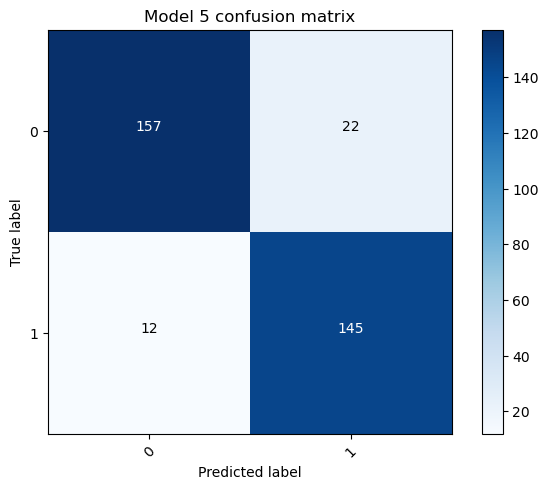

In [114]:
pred_5_classes = np.rint(pred_5)
confusion_mtx = confusion_matrix(test_labels, pred_5_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 5 confusion matrix')
plt.savefig('ConfusionMatrixModel5(CBIS-DDSM).png')

Number of test images: 336
Mispredictions: 48
Hard mispred: 16


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



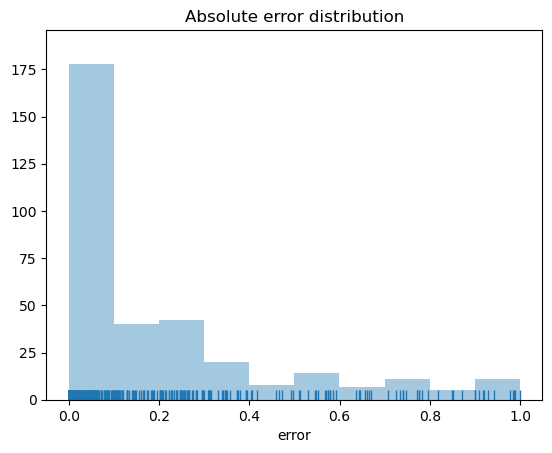

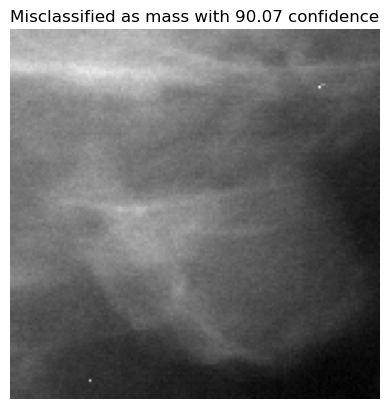

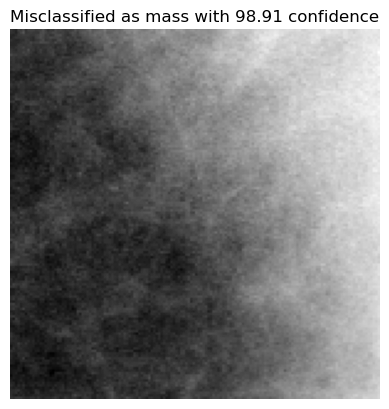

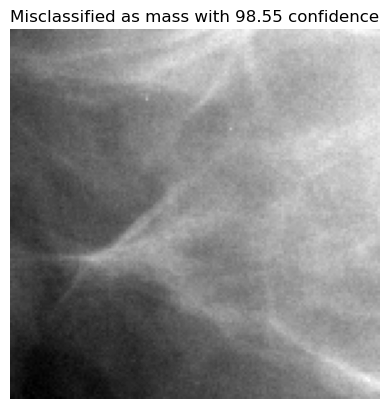

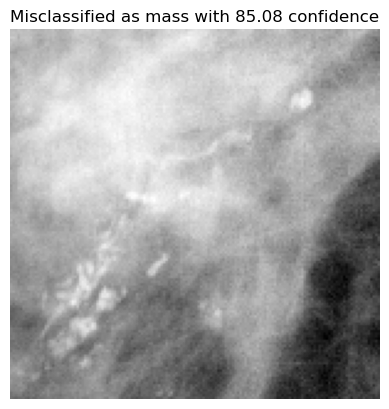

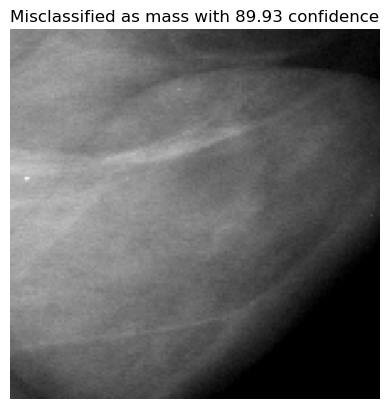

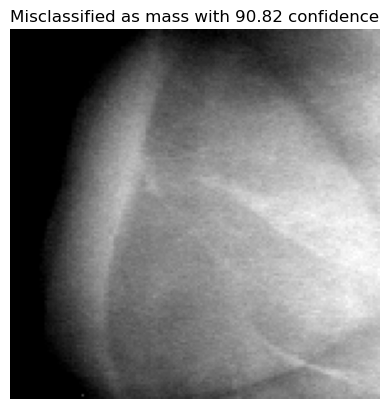

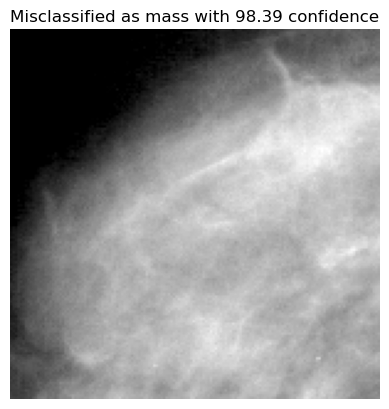

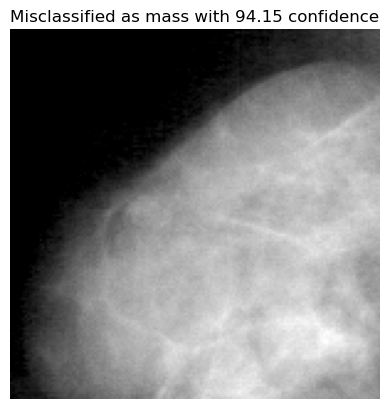

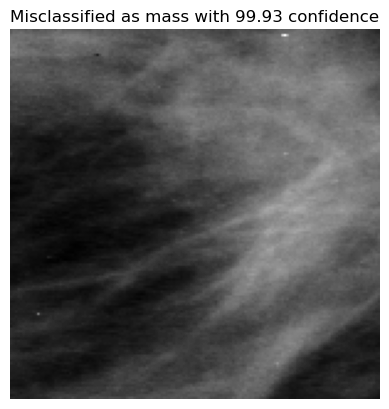

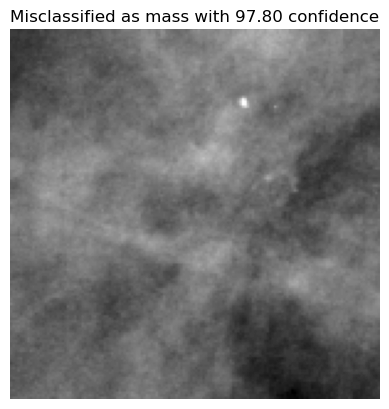

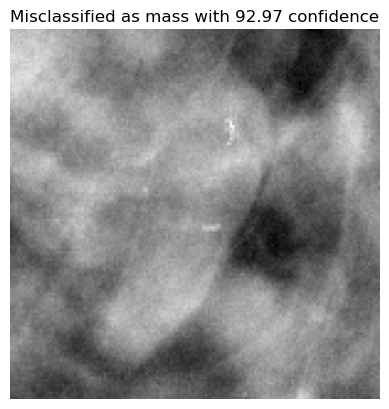

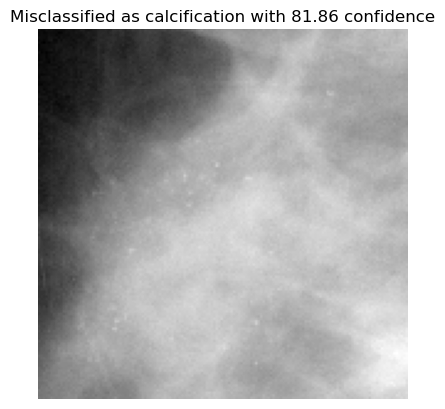

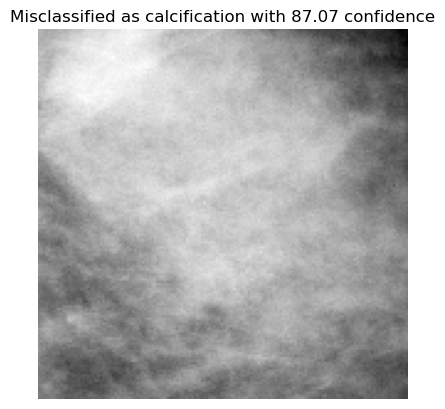

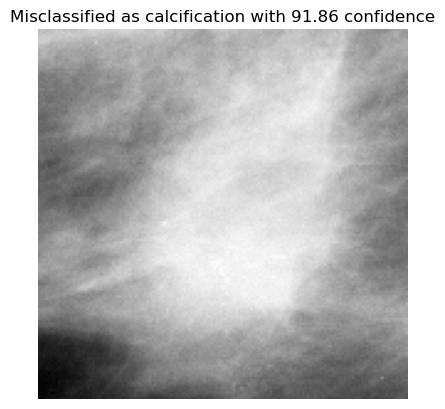

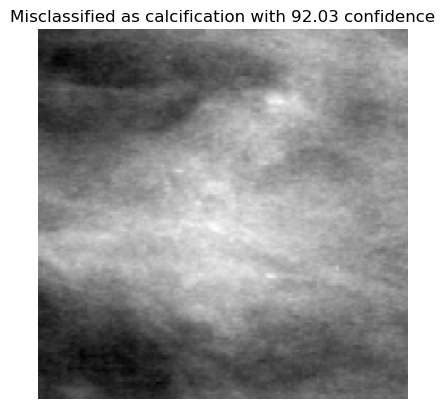

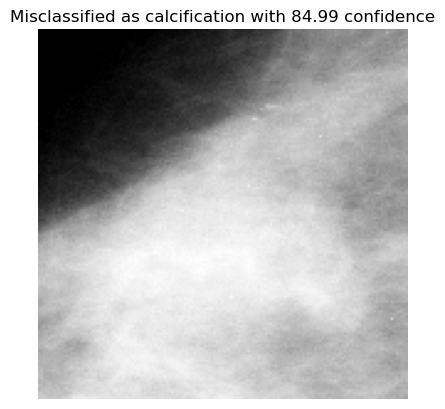

In [104]:
show_error_stats(errors_2, mispred_2, hard_mispred_2)

Number of test images: 336
Mispredictions: 38
Hard mispred: 11


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



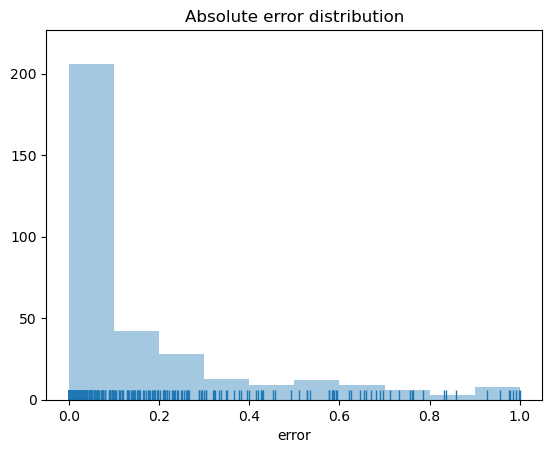

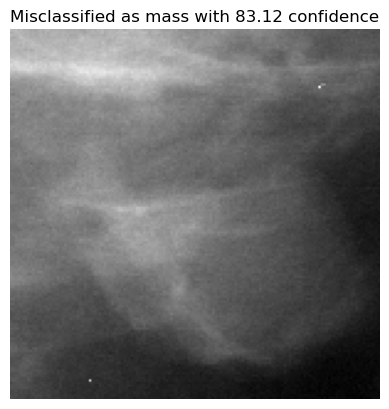

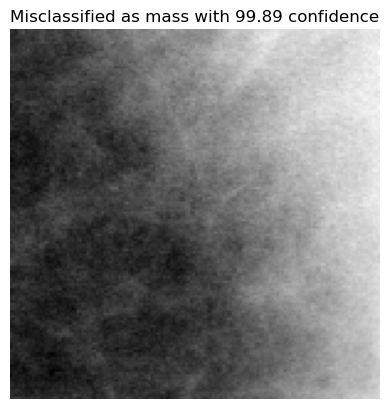

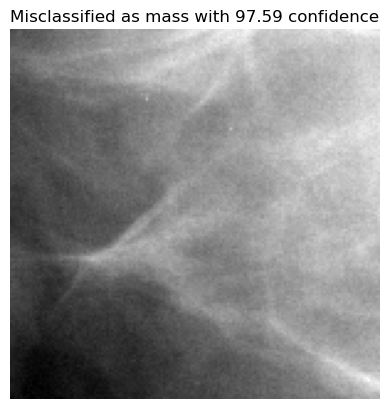

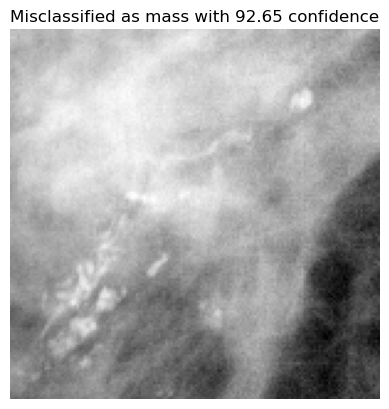

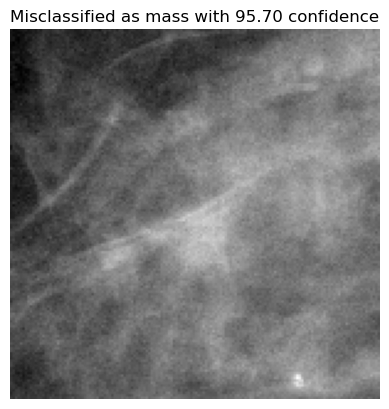

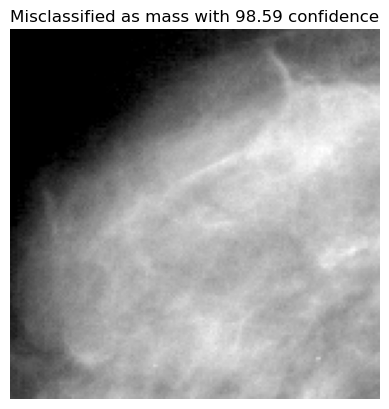

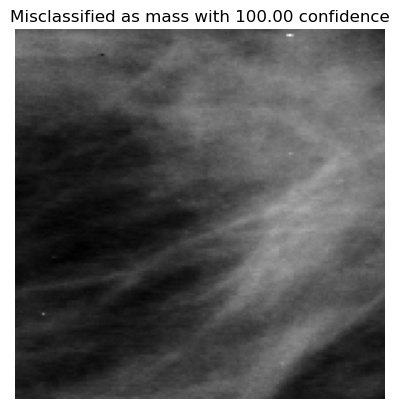

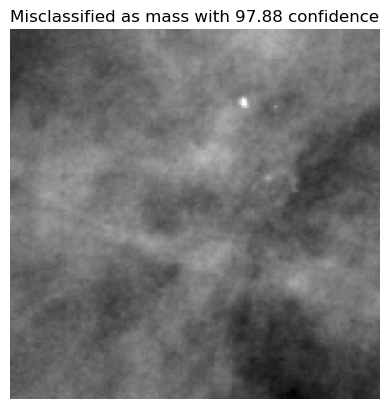

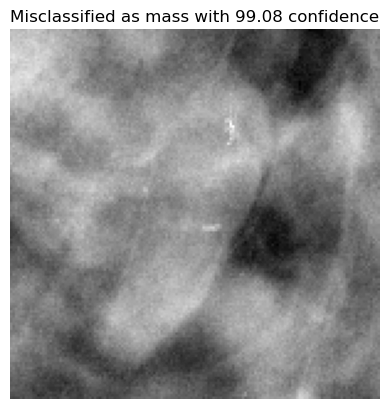

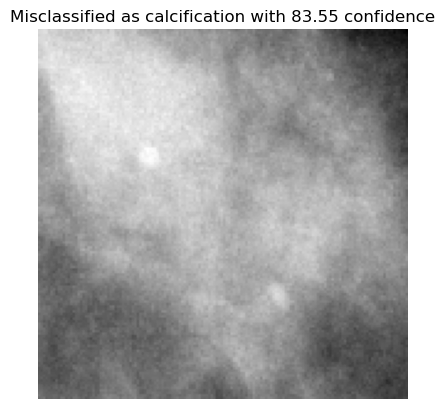

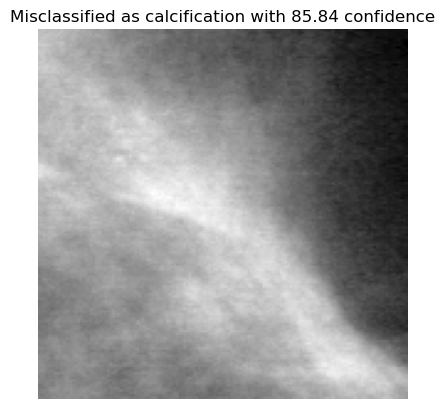

In [105]:
show_error_stats(errors_3, mispred_3, hard_mispred_3)

Number of test images: 336
Mispredictions: 34
Hard mispred: 14


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



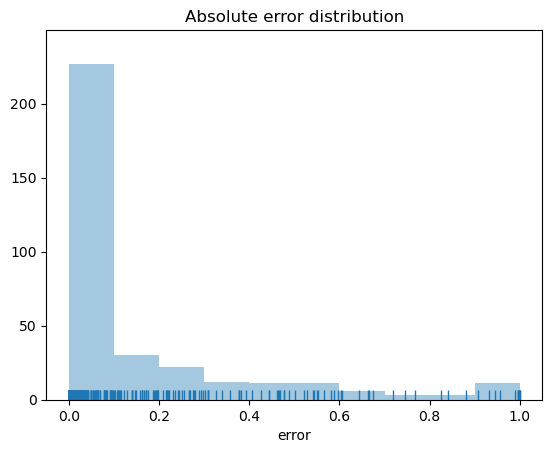

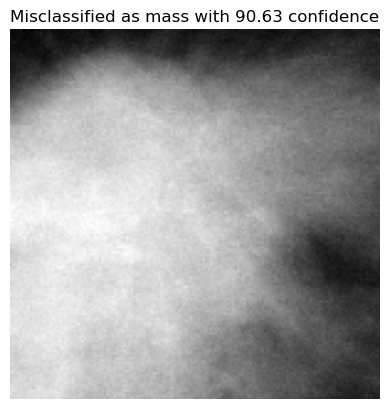

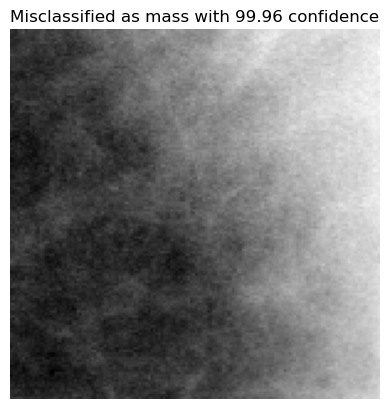

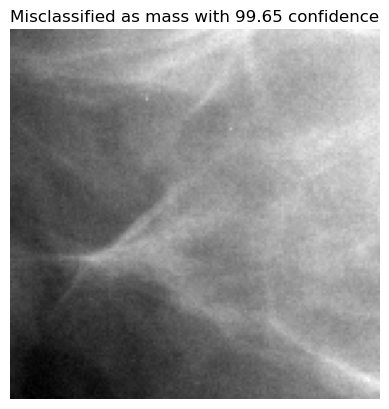

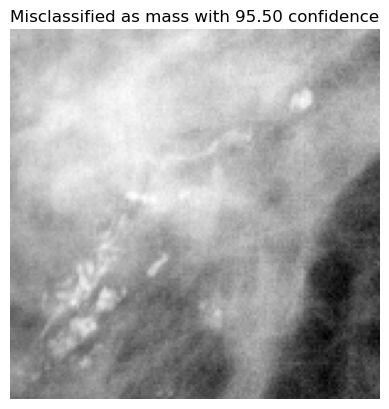

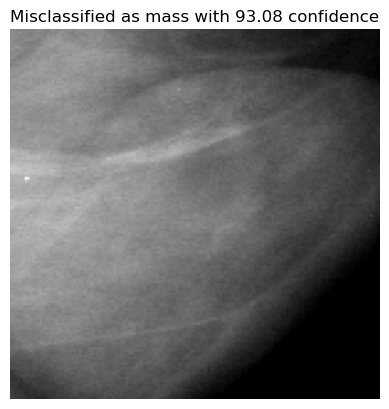

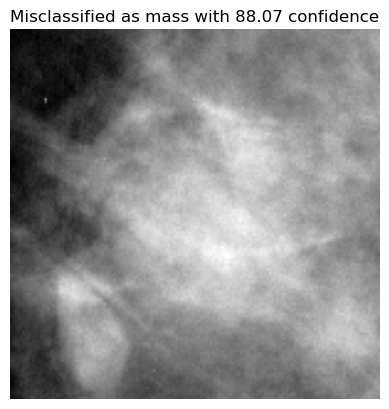

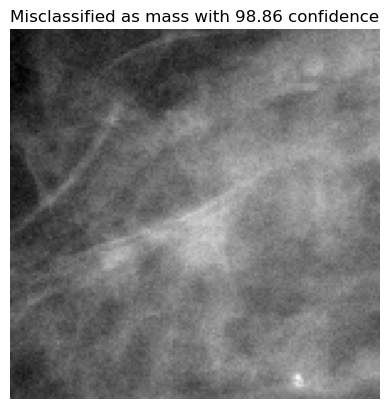

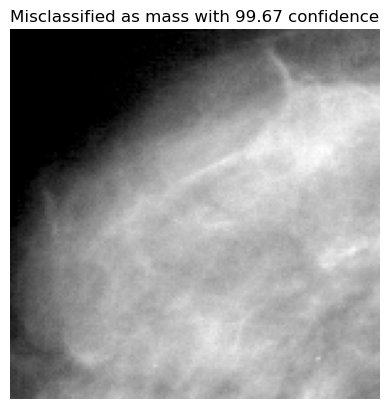

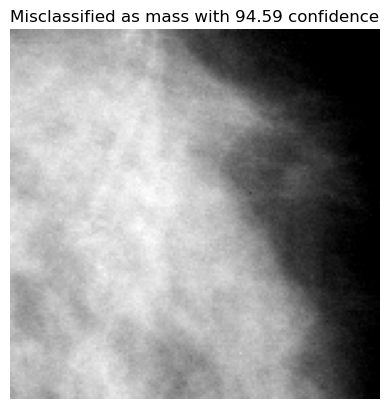

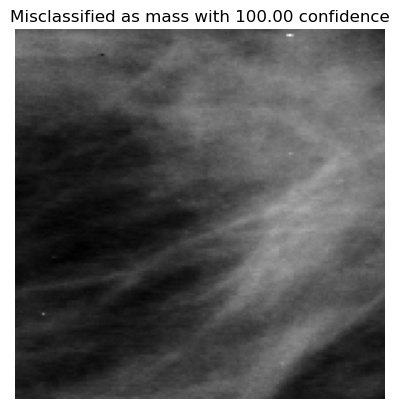

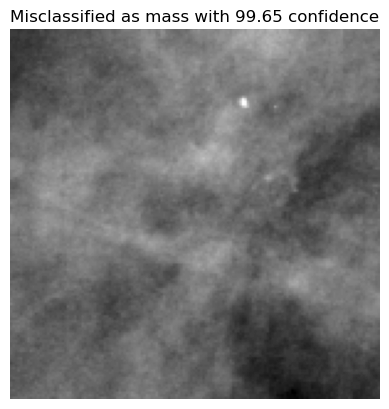

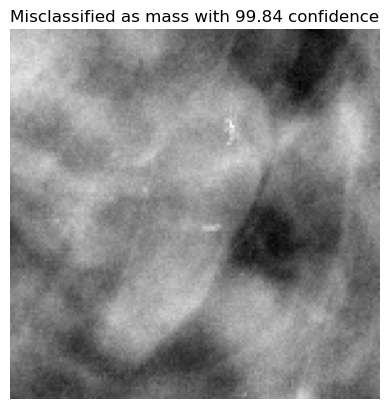

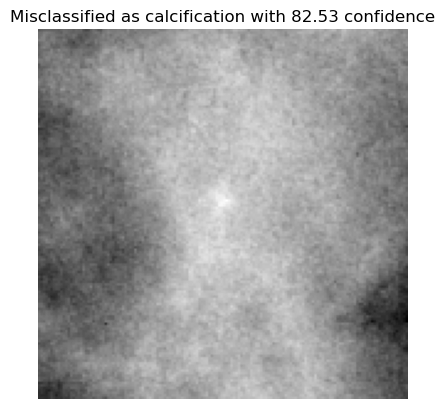

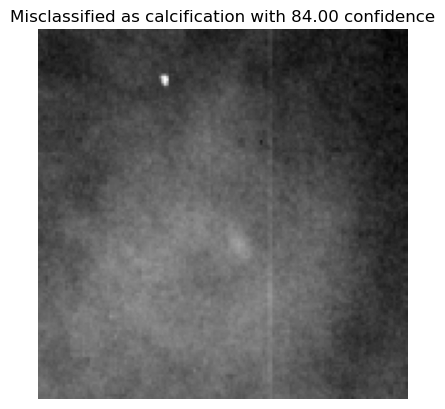

In [106]:
show_error_stats(errors_5, mispred_5, hard_mispred_5)

In [109]:
correct_2 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_2), test_labels)])
correct_3 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_3), test_labels)])
correct_5 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_5), test_labels)])

wrong_2 = np.logical_not(correct_2)
wrong_3 = np.logical_not(correct_3)
wrong_5 = np.logical_not(correct_5)

hard_wrong_2 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_2), test_labels)])
hard_wrong_3 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_3), test_labels)])
hard_wrong_5 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_5), test_labels)])

differ_2_3 = np.logical_xor(correct_2, correct_3)
differ_2_5 = np.logical_xor(correct_2, correct_5)
differ_3_5 = np.logical_xor(correct_3, correct_5)

wrong_all = np.logical_and(wrong_2, wrong_3, wrong_5)
hard_wrong_all = np.logical_and(hard_wrong_2, hard_wrong_3, hard_wrong_5)

print("Model 2 and 3 differ for %d samples" % np.sum(differ_2_3))
print("Model 2 and 5 differ for %d samples" % np.sum(differ_2_5))
print("Model 3 and 5 differ for %d samples" % np.sum(differ_3_5))

print("%d samples were misclassified by all three" % np.sum(wrong_all))
print("%d samples were hard misclassified by all three" % np.sum(hard_wrong_all))

Model 2 and 3 differ for 30 samples
Model 2 and 5 differ for 40 samples
Model 3 and 5 differ for 18 samples
28 samples were misclassified by all three
8 samples were hard misclassified by all three


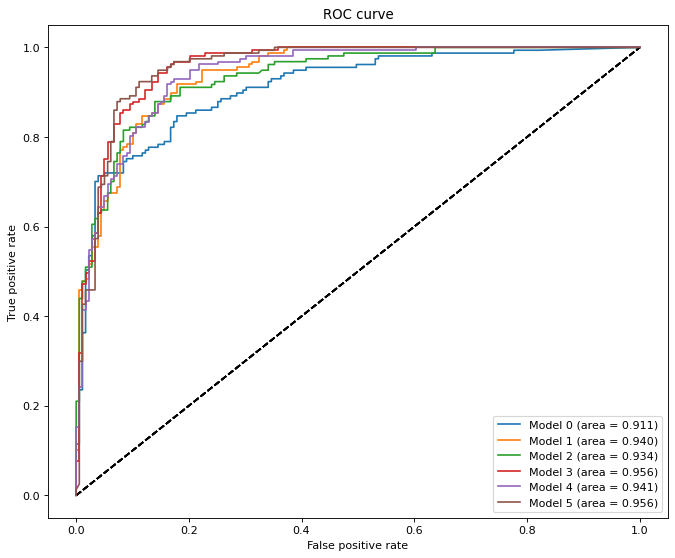

In [125]:
plot_roc([pred_0, pred_1, pred_2, pred_3, pred_4, pred_5], names=['Model 0','Model 1','Model 2', 'Model 3','Model 4', 'Model 5'])